# <center> Поиск аномалий в данных </center>

![](https://i.pinimg.com/originals/e5/c4/0d/e5c40dd06a9cdda2ac88101897606543.gif)

## <center> Как 3 сигмы, только лучше </center>

# Зачем вообще искать аномалии?


<details><summary>CLICK ME</summary>
<p>

- Предобработка данных: убираем выбросы, чтобы не переобучиться
- Анализ выбросов: хотим найти, понять и обезвредить
- Поиск аномалий как самоцель

**Поиск аномалий** может быть как конечной целью анализа и построения моделей, так и промежуточным этапом подготовки и очистки данных. В первом сценарии мы хотим научиться для каждого объекта выборки выносить вердикт, является ли он аномальным/нестандартным, а во-втором мы находим и убираем выбросы в данных, чтобы в дальнейшем получить более устойчивые модели. 

В [определении](https://scikit-learn.org/stable/modules/outlier_detection.html) из документации scikit-learn, здача поиска аномалий разделяется на два возможных типа:

- **Outlier detection** (поиск выбросов): в тренировочной выборке содержатся выбросы, которые определяются как наблюдения, лежащие далеко от остальных. Таким образом, алгоритмы для детектирования выбросов пытаются найти регионы, где сосредоточена основная масса тренировочных данных, игрорируя аномальные наблюдения.
- **Novelty detection** (поиск "новизны"): тренировочная выборка не загрязнена выбросами, и мы хотим научиться отвечать на вопрос "является ли новое наблюдение выбросом". 

</p>
</details>


## Сложности при поиске аномалий

На практике задача поиска аномалий зачастую не сводится к построению бинарного классификатора "выброс/не выброс". Реальные данные редко бывают размечены и мы вынуждены использовать методы обучения без учителя. 

Одновременно с этим возникает вопрос о построении надежной схемы валидации, ведь если "правильных ответов" у нас нет, то и понять, насколько алгоритм справляется со своей задачей, уже сложнее. Здесь очень помогут экспертные оценки о проценте аномальных объектов, которые ожидаются в выборке, так как с ними можно будет сравнивать прогнозные значения и варьировать тем самым чувствительность алгоритмов. 

Если же поиск и очистка от аномалий - это шаг в подготовке данных для последующего моделирования, то можно использовать стандартные подходы: разбиение на train/test, кросс-валидацию и т.д. Конечно, чтобы избежать переобучения, очистка в этом случае должна проводиться только на тренировочной части датасета.

# Методы

## Supervised?

## Unsupervised

<details><summary>Самые простые?</summary>
<p>

- Визуально: по гистограммам, скаттерплотам, боксплотам
- Базовые статистики - отклонение от среднего, перцентили, квантили
- Статистические тесты, те самые 3 сигмы

</p>
</details>

Посложнее:
- Distance-based: находим центроиды/средние/кластеры "хороших" наблюдений и считаем расстояние до них, если расстояние больше некоторого порогового значения - аномалия 


- Density-based: похожее, но по вероятностям/плотностям, если плотность ниже порога - аномалия (DBSCAN)


- Model-based: строим модельки, а они уже разберутся
    - Линейные методы: пытаемся построить некоторую линейную разделяющую гиперплоскость между "хорошими" и "аномальными значениями" (One-Class SVM)
    - Деревянные методы: строим решающее дерево, чтобы понять, сколько раз пришлось делить выборку, чтобы добраться до конкретной точки (Isolation Forest https://quantdare.com/isolation-forest-algorithm/)
    - Deep-learning: строим сжатую репрезентацию наших данных (autoencoders) и дальше используем distance/density/models подход на подготовленных данных

In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

# from MulticoreTSNE import MulticoreTSNE as TSNE
from tqdm import tqdm_notebook


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
def data_loader(n, path_attacks='data/attacks/', path_logins='data/logins/'):
    """Loads data, given id"""
    files_attacks = os.listdir(path='data/attacks/')
    files_attacks = [f for f in files_attacks if '.csv' in f]
    files_attacks = [f for f in files_attacks if f.split('-')[0] == str(n)]
    
    login_data = pd.read_csv(path_logins+"{}.csv".format(n))
      
    attack_data = pd.DataFrame()    
    for f in files_attacks:
        attack_data = pd.concat([attack_data, pd.read_csv(path_attacks+f)], axis=0)
        
    return login_data, attack_data

class scaler_df(MinMaxScaler):
    """Wrapper for default scalers to produce dataframe results"""
    def transform(self, x):
        z = super(scaler_df, self).transform(x)
        return pd.DataFrame(z, index=x.index, columns=x.columns)
    
def plot_confusion(true_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted: Original','Predicted: Attacker'], index=['Actual: Original','Actual: Attacker'])
    plt.figure(figsize = (5,5))
    sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [5]:
login_data, attack_data = data_loader(4)

FileNotFoundError: [Errno 2] No such file or directory: 'data/attacks/'

In [11]:
login_data.head()

,S,S,o,o.1,p,p.1,p.2,p.3,a,a.1,...,u,u.1,s,s.1,i,i.1,s.2,s.3,1,1.1
0,0,8,624,629,1054,1059,1260,1263,1625,1628,...,3144,3156,3607,3611,3767,3770,3941,3946,4565,4571
1,0,12,568,576,1033,1041,1260,1263,1817,1821,...,3782,3787,4316,4324,4703,4708,5192,5221,6064,6067
2,0,5,499,503,1546,1551,1731,1734,2130,2136,...,4119,4121,4685,4688,5231,5235,5844,5847,6490,6493
3,0,10,738,785,1323,1333,1500,1508,2198,2201,...,3566,3570,4187,4190,4662,4665,5080,5087,5675,5679
4,0,3,531,536,936,939,1135,1139,1585,1588,...,4741,4749,5307,5310,5688,5690,6221,6225,6889,6892


In [12]:
attack_data.head()

,S,S,o,o.1,p,p.1,p.2,p.3,a,a.1,...,u,u.1,s,s.1,i,i.1,s.2,s.3,1,1.1
0,0,6,257,264,525,533,691,698,1325,1331,...,2291,2298,2474,2480,2590,2597,2754,2761,4191,4195
1,0,9,300,307,570,578,752,759,1169,1176,...,1952,1959,2116,2123,2250,2259,2369,2375,3101,3107
2,0,9,450,457,720,727,887,895,1203,1209,...,2045,2051,2219,2226,2349,2356,2499,2506,3935,3941
3,0,11,395,402,663,669,813,818,1028,1034,...,1679,1686,1829,1836,1928,1935,2045,2051,2894,2901
4,0,10,384,392,654,661,819,825,1019,1026,...,1870,1877,2084,2090,2183,2189,2349,2355,3449,3455


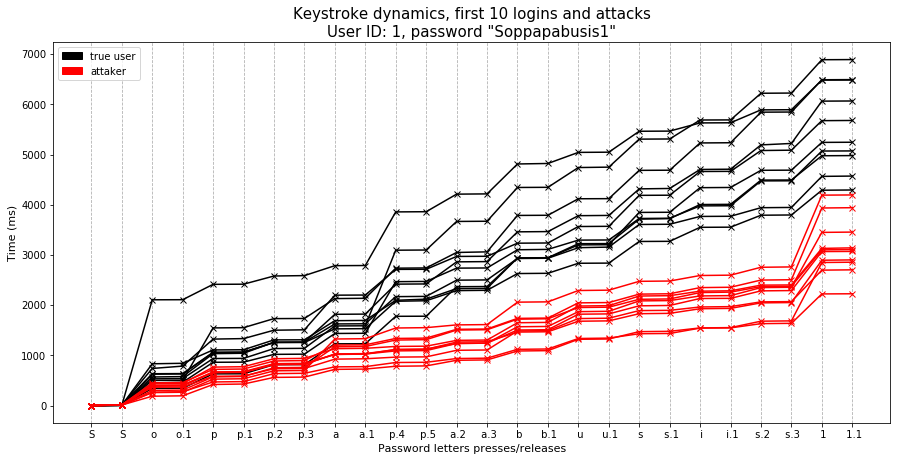

In [13]:
password = "".join([letter.strip()[0] for letter in login_data.columns][::2])
plt.figure(figsize=(15, 7))
plt.title('Keystroke dynamics, first 10 logins and attacks\nUser ID: 1, password "{}"'.format(password), size=15)
for i in range(10):
    plt.plot(login_data.iloc[i], 'x-', label="login #{}".format(i), color='black')
    
for i in range(10):
    plt.plot(attack_data.iloc[i], 'x-', label="login #{}".format(i), color='red')
    
plt.ylabel("Time (ms)", size=11)
plt.xlabel("Password letters presses/releases", size=11)
plt.grid(axis='x', linestyle='--')

red_patch = mpatches.Patch(color='red', label='attaker')
black_patch = mpatches.Patch(color='black', label='true user')

plt.legend(handles=[black_patch, red_patch])
plt.show()

In [14]:
def feature_transformer(data):
    """Performs feature extraction from a given dataset"""
    # Time between press and release
    time_press_release = np.diff(data).T[::2].T

    time_press_release = pd.DataFrame(
        time_press_release, 
        columns=['tpr_{}'.format(i) for i in range(time_press_release.shape[1])]
    )

    # Average of key hold
    avg_time_key_hold = np.average(time_press_release, axis=1)

    avg_time_key_hold = pd.DataFrame(
        avg_time_key_hold, 
        columns=['avg_tkh']
    )

    # Time between consecutive key presses
    time_consec_key_press = np.diff(data[data.columns[::2]])

    time_consec_key_press = pd.DataFrame(
        time_consec_key_press, 
        columns=['tckp_{}'.format(i) for i in range(time_consec_key_press.shape[1])]
    )

    # Time between key release and next key press
    cols = [(data.columns[i], data.columns[i+1]) for i in range(1, len(data.columns)-1, 2)]
    cols = list(sum(cols,()))
    time_key_release_next = np.diff(data[cols]).T[::2].T

    time_key_release_next = pd.DataFrame(
        time_key_release_next, 
        columns=['tkrn_{}'.format(i) for i in range(time_key_release_next.shape[1])]
    )

    preprocessed_data = pd.concat(
        (
             time_press_release, 
             avg_time_key_hold,
             time_consec_key_press, 
             time_key_release_next
        ), axis=1
    )
    return preprocessed_data

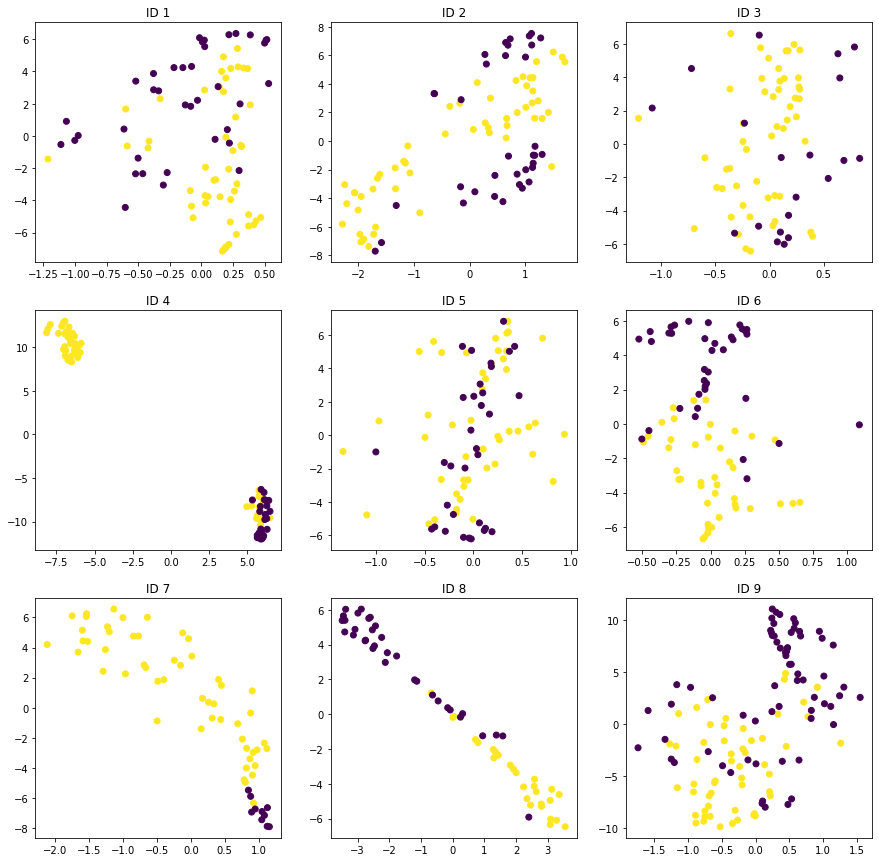

In [15]:
def tsne_preprocessing(login_data, attack_data):
    
    finalscaled = pd.concat([login_data, attack_data])
    tsne = TSNE(n_jobs=-1)
    tsne_representation = tsne.fit_transform(finalscaled)
    labels = np.concatenate((np.ones(len(login_data)), np.zeros(len(attack_data))-1))

    return tsne_representation, labels

index = 1 
f, axarr = plt.subplots(3, 3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        login_data, attack_data = data_loader(index)
        tsne_representation, labels = tsne_preprocessing(login_data, attack_data)
        
        axarr[i, j].scatter(tsne_representation[:, 0], tsne_representation[:, 1], c=labels)
        axarr[i, j].set_title('ID {}'.format(index))
        index += 1

In [320]:
login_data, attack_data = data_loader(4)

full_df = pd.concat([scaled_login, scaled_attack])

true_labels = np.concatenate(
    [
        np.zeros(shape=scaled_login.shape[0]), 
        np.ones(shape=scaled_attack.shape[0])
    ]   
)

# Distance-based

In [79]:
class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `threshold` based on `percentile`.
    
    Predict method uses `threshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> outlier.
    
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [90]:
scaler = scaler_df()
euclidian_model = DistanceOutliers(metric='euclidean', percentile=80)

scaled_login = scaler.fit_transform(feature_transformer(login_data))
scaled_attack = scaler.transform(feature_transformer(attack_data))

euclidian_model.fit(scaled_login)

In [93]:
euclidian_model.predict(full_df)

array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

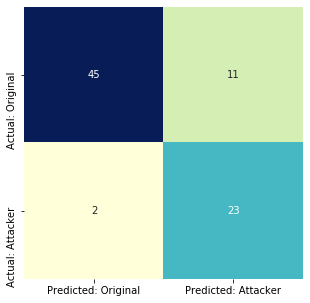

In [300]:
plot_confusion(true_labels, euclidian_model.predict(full_df))

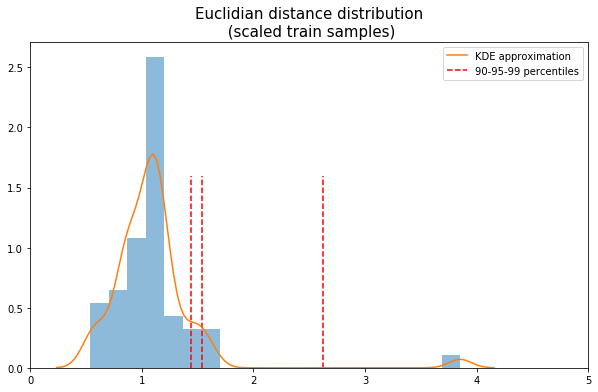

In [95]:
distances_train = cdist(scaled_login.mean(axis=0).values.reshape(-1, 1).T, scaled_login).reshape(-1)
distances_test = cdist(scaled_login.mean(axis=0).values.reshape(-1, 1).T, scaled_attack).reshape(-1)

plt.figure(figsize=(10, 6))

plt.hist(distances_train, density=True, alpha=0.5, bins=20)
sns.kdeplot(distances_train, label='KDE approximation')

plt.vlines(
    np.percentile(distances_train, [90, 95, 99]), 
    ymin=0, ymax=1.6, 
    linestyles='dashed', 
    colors='red', 
    label='90-95-99 percentiles'
)

plt.title("Euclidian distance distribution\n (scaled train samples)", size=15)
plt.legend()

plt.xlim(0, 5)
plt.show()

# <center> Density-based </center>

In [1]:
outlier_percentage = 1.

eps = 1e-5
while outlier_percentage>0.1:
    model = DBSCAN(eps=eps).fit(scaled_login)
    labels = model.labels_
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = np.mean(sum(labels==1))
    eps += 0.005
    
model = DBSCAN(eps)
model.fit(full_df.values)
predicted_labels = np.array([1 if label == -1 else 0 for label in model.labels_])

NameError: name 'DBSCAN' is not defined

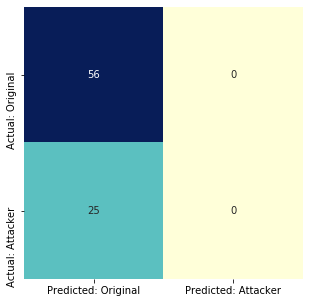

In [319]:
plot_confusion(true_labels, predicted_labels)

# <center> One-Class SVM </center> 

## Коротко о Support Vector Machine

Если совсем вкратце, SVM - базовая линейная модель. Основная идея алгоритма (в случае с классификацией) - разделить классы гиперплоскостью так, чтобы максимизировать расстояние (зазор) между ними. Изначально алгоритм был способен работать только с линейно разделимыми классами, однако в 90-е годы прошлого века метод стал особенно популярен из-за внедрения "Kernel Trick" (1992), позволившего эффективно работать с линейно неразделимыми данными. 

![](https://sandipanweb.files.wordpress.com/2018/04/svm_slack.png?w=676)

## Kernel Trick

Ядро (kernel) - это функция, которая способна преобразовать признаковое пространство (в том числе нелинейно), без непосредственного преобразования признаков. 

Крайне эффективна в плане вычисления и потенциально позволяет получать бесконечноразмерные признаковые пространства. 

Идея заключается в том, что классы, линейно неразделимые в текущем признаковом пространстве, могут стать разделимыми в пространствах более высокой размерности:

![](https://miro.medium.com/max/1838/1*eU9PzjVcLNbNEzBC2g_iWg.jpeg)

## One Class SVM

One Class SVM - это одна из форм классического алгоритма, однако, как следует из названия, для его обучения нам достаточно иметь всего один класс. 

Если мы имеем дело с задачей novelty detection, где для тренировки нам доступны только "хорошие" наблюдения без аномалий, то мы можем воспользоваться этой моделью и научиться для каждого нового наблюдения говорить, является ли оно аномальным или нет.

Общая идея: преобразовать признаковое пространство и провести разделяющую гиперплоскость так, чтобы наблюдения лежали как можно дальше от начала координат:

![](https://www.researchgate.net/profile/Hany_Alashwal/publication/242572058/figure/fig1/AS:393295319584771@1470780319210/Classification-in-one-class-SVM.png)

В результате мы получаем границу, по одну сторону которой максимально плотно упакованы наблюдения из нашей чистой тренировочной выборки, а по другую будут находится аномальные значения, не похожи на то, что алгоритм видел во время обучения. 


In [302]:
model = OneClassSVM(nu=0.1)
model.fit(scaled_login)
preds = model.predict(full_df)

In [303]:
preds = np.array([1 if label == -1 else 0 for label in preds])

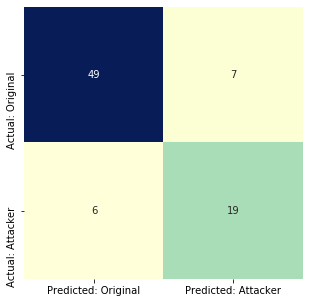

In [305]:
plot_confusion(true_labels, preds)

## Плюсы и минусы

\+ Благодаря kernel trick, модель способна проводить **нелинейные разделяющие границы**

\+ Особенно удобно использовать, когда в данных недостаточно "плохих" наблюдений, чтобы использовать стандартный подход обучения с учителем - бинарную классификацию

\- Может очень сильно **переобучиться** и выдавать большое количество ложно отрицательных результатов, если разделяющий зазор слишком мал

\- И, конечно, нужно быть абсолютно уверенным, что **тренировочные данные не содержат никаких выбросов**, иначе алгоритм будет считать их нормальными наблюдениями

# <center> Isolation Forest </center>

https://quantdare.com/isolation-forest-algorithm/

In [329]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.2, max_features=0.4, bootstrap=True)

model.fit(scaled_login)

preds = model.predict(full_df)
preds = np.array([1 if label == -1 else 0 for label in preds])

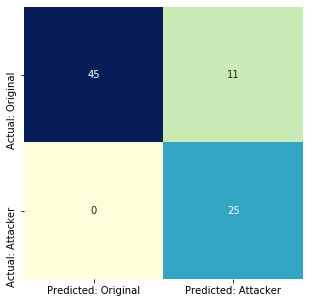

In [330]:
plot_confusion(true_labels, preds)

## Плюсы и минусы

\+ Снова **нелинейные разделяющие границы**, плюс интуитивно понятные принципы работы

\+ Снова удобно использовать, когда не можем в бинарную классификацию

\+ В отличие от One-Class SVM не требует чистого датасета

\- Очень сложная настройка параметров, которую практически нереально провести, не имея хотя бы минимальной разметки или предположения о количестве "грязных" наблюдений - параметр `contamination`